# DAY 1
  Rakam benzerliği üzerine örnek Siamese Network çalışması. Birbirinin kopyası olan iki neural network var, iki image input verildiğinde bu networkler birer output vektörü veriyor. Resimler aynı şeyi gösteriyorsa, output vectorlerinin de benzer olması isteniyor. Output vectorleri arasındaki ilişki euclidean distance vb. yöntemlerle hesaplanıyor. Birbirinin kopyası olan iki network, aynı labela sahip imageların output vectorleri arasındaki euclidean distance düşürülecek şekilde eğitiliyor. Tahmin yapılırken, outputlar arasındaki euclidean distance ne kadar düşükse o kadar benzer olduğu anlamına geliyor.


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import random
from keras.datasets import mnist # containts handwritten digit images.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from keras import backend as K

In [ ]:
num_classes = 10
epochs = 10  # epochs updated from 20 to 10.
 
def euclid_dis(vecs):
    vec1,vec2 = vecs
    sum_square = K.sum(K.square(vec1-vec2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
    return np.array(pairs), np.array(labels)
 
def create_base_net(input_shape):
    input = Input(shape = input_shape)
    x = Conv2D(1, (5,5), activation = 'tanh')(input)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Conv2D(1, (5,5), activation = 'tanh')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'tanh')(x)
    model = Model(input, x)
    model.summary()
    return model
 
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5 # flatten predictions to 1-D array and mark if y_pred( distance between output vectors) < 0.5
    return np.mean(pred == y_true)
 
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype))) # if distance < 0.5, mark as the same digit.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

In [ ]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
 
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
 
# network definition
base_network = create_base_net(input_shape)

In [ ]:
input_a = Input(shape = input_shape)
input_b = Input(shape = input_shape)

 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis,
                  output_shape = eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)
#train
model.compile(loss=contrastive_loss, optimizer = 'adam', metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

In [ ]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
 
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 15

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items): # print image pairs that are compared with each other.
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
for i in range(number_of_items):
    print(y_pred[i])

Sırasıyla imageların output vektörleri arasındaki euclidean distancelar, aynı rakamlar arasındaki distancelar küçük


#DAY 2





##Local Binary Patterns

Trying local binary pattern (lbp) algorithm. The main purpose of the algorithm is detecting textures in images. Also used for face recognition. https://en.wikipedia.org/wiki/Local_binary_patterns https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

Library for lbp calculations: https://scikit-image.org/ OpenCV also has an implementation, but it's optimized for face recognition. Example from the library: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html



Type Markdown and LaTeX:  𝛼2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy import sparse

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

In [ ]:
radius = 1 # radius of circle 
n_points = 8 * radius
METHOD = "nri_uniform" 

images = []

# load 4 example images from 
images.append(data.brick()) 
images.append(data.moon())
images.append(data.gravel())
images.append(data.clock())
lbps = []
lbps.append(local_binary_pattern(images[0], n_points, radius, METHOD))
lbps.append(local_binary_pattern(images[1], n_points, radius, METHOD))
lbps.append(local_binary_pattern(images[2], n_points, radius, METHOD))
lbps.append(local_binary_pattern(images[3], n_points, radius, METHOD))
# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=len(images), figsize=(9, 6))
plt.gray()


i = 0
for ax in ax_img:
    ax.imshow(images[i])
    i += 1
j = 0
counts_arr = []
for ax in ax_hist:
    counts, _, bars = hist(ax, lbps[j])
    ax.set_ylim(top = np.max(counts))
    ax.set_xlim(right = 59)
    lbps[j] = lbps[j].ravel()
    unique, counts = np.unique(lbps[j], return_counts=True)
    dictionary = dict(zip(unique, counts))
    
    count_vec = []
    for k in range(59):
        if float(k) in dictionary:
            count_vec.append(dictionary[float(k)])
        else:
            count_vec.append(0)
    print( count_vec)
    counts_arr.append(count_vec)
    print(dictionary)
    j += 1
counts_Arr = np.array(counts_arr)

print(cosine_similarity(counts_Arr))
ax_hist[0].set_ylabel('Percentage')

for ax in ax_img:
    ax.axis('off')

##API for Image Similarity


Found an API that calculates a similarity score between different images. No information about the implementation.

In [ ]:
import requests
r = requests.post(
    "https://api.deepai.org/api/image-similarity",
    data={
        'image1': 'https://image.optisaglik.com/L%C4%B0STER%C4%B0NECOOLM%C4%B0NT250ML_585e96ae-86ee-4c33-a6a1-f5e4fceaf114.jpg',
        'image2': 'https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_960,f_auto/DCTM_Penguin_UK_DK_AL526630_wkmzns.jpg',
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
print(r.json())

# DAY 3


## Pretrained Models

It could be possible to build upon pretrained models. Check: https://towardsdatascience.com/building-a-similar-images-finder-without-any-training-f69c0db900b5 The model should be

## Feature Extraction 

### SIFT


Scale-invariant feature transform (SIFT) is a feature detection algorithm that might be used for detecting objects in images. After detecting objects in an image, their similarities might be calculated better. The algorithm was patented until 2020 and there are comments that state it's slow. Might be tested later.

SIFT keypoints of objects are first extracted from a set of reference images and stored in a database. An object is recognized in a new image by individually comparing each feature from the new image to this database and finding candidate matching features based on Euclidean distance of their feature vectors. From the full set of matches, subsets of keypoints that agree on the object and its location, scale, and orientation in the new image are identified to filter out good matches.

From: https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

### HoG

https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/ Histogram of Gradients(HoG) is a feature extractor to detect objects in images. Extracts the gradient vector at each pixel by comparing values of neighbour pixels. Creates an histogram from the gradients.

In [ ]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import sys
%matplotlib inline


#reading the image
img1 = imread('https://cdn.dsmcdn.com/mnresize/415/622/ty11/product/media/images/20200918/13/11102381/87294537/0/0_org_zoom.jpg')
img2 = imread('https://cdn.dsmcdn.com/mnresize/415/622/ty8/product/media/images/20200722/16/5629751/6678414/1/1_org_zoom.jpg')

In [ ]:
fd, hog_image1 = hog(img1, orientations=9, pixels_per_cell=(8,8), 
                    cells_per_block=(2,2), visualize=True, multichannel=True)
fd, hog_image2 = hog(img2, orientations=9, pixels_per_cell=(8,8), 
                    cells_per_block=(2,2), visualize=True, multichannel=True)


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1[0].imshow(img1, cmap=plt.cm.gray) 
ax2[0].imshow(img2, cmap=plt.cm.gray) 
ax1[0].set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled1= exposure.rescale_intensity(hog_image1, in_range = (0,10)) 
hog_image_rescaled2= exposure.rescale_intensity(hog_image2, in_range = (0,10)) 


ax1[1].imshow(hog_image_rescaled1, cmap=plt.cm.gray) 
ax2[1].imshow(hog_image_rescaled2, cmap=plt.cm.gray) 
ax1[1].set_title('Histogram of Oriented Gradients')

plt.show()

##OPENCV- Thresholding

In [ ]:
import pandas 
import requests
from PIL import Image
import cv2
import numpy as np
import urllib
import matplotlib.pyplot as plt

def crop(myurl):
  req = urllib.request.urlopen(myurl)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  img = cv2.imdecode(arr, -1) # 'Load it as it is
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  ## (2) Morph-op to remove noise
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  ## (3) Find the max-area contour
  cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

  cnt = sorted(cnts, key=cv2.contourArea)[-1]

  ## (4) Crop and save it
  x,y,w,h = cv2.boundingRect(cnt)
  dst = img[y:y+h, x:x+w]
  return img, dst

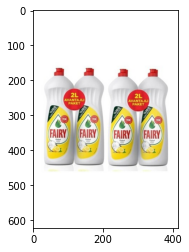

In [ ]:
croppedImage = crop("https://cdn.dsmcdn.com/mnresize/415/622/assets/product/media/images/20200106/10/1954919/61625403/1/1_org_zoom.jpg")[1]

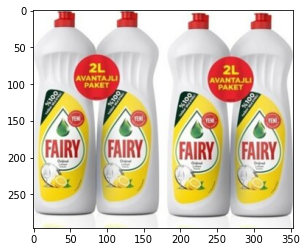

In [ ]:
plt.imshow(croppedImage, cmap=plt.cm.gray)

In [ ]:
df = pandas.read_csv('images.csv')

In [ ]:
def printCropped(index, n = 5):
    fig, axlist = plt.subplots(2, n, figsize=(16, 8), sharex=True, sharey=True) 
    subset = df[index*n : (index+1)*n]
    subset['images'] = subset['product_image_url'].apply(lambda x : crop(x))
    images = subset['images'].tolist()
    i = 0
    for img,cropped in images:
        print(img.shape)
        print(cropped.shape)
        axlist[0][i].imshow(img)
        axlist[1][i].imshow(cropped)
        i +=1